In [1]:
scriptspath = os.path.join(os.getcwd(), '..', 'scripts')
sys.path.append(scriptspath)

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule

from scipy.spatial.distance import pdist, squareform
import wget

from data_processing import extract_data

import string

%matplotlib inline

In [4]:
# download data
pdb = '4rb6Y'  # other examples - 5cajA , 4x5lA
a3m_url = 'https://files.ipd.uw.edu/krypton/%s.i90c75.a3m'%pdb
pdb_url = 'https://files.ipd.uw.edu/krypton/%s.pdb'%pdb
cf_url  = 'https://files.ipd.uw.edu/krypton/%s.cf'%pdb
urls    = [a3m_url, pdb_url, cf_url]
fnames  = [url.split('/')[-1] for url in urls]

for i, url in enumerate(urls):
    fname = fnames[i]
    if not os.path.exists(fname):
        wget.download(url=url, out=fname);

# get the MSA one hot representation, the sequence weights and the contacts
a3mfname, _, cffname = fnames
X, W, cons = extract_data(a3mfname, cffname)
N, L, A = X.shape

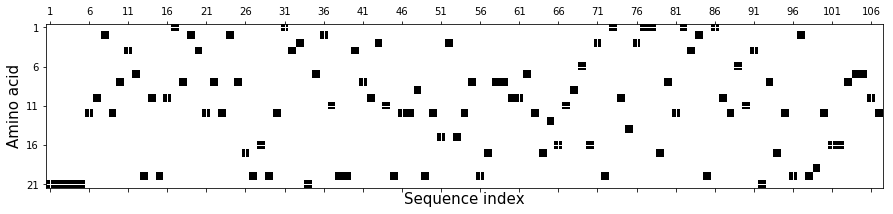

In [6]:
# An example sequence one hot encoding  
plt.figure(figsize=(15, 5))
plt.spy(X[np.random.randint(0, len(X))].T)
plt.xticks(np.arange(0, 107, 5), np.arange(0, 107, 5)+1)
plt.yticks(np.arange(0, 21, 5), np.arange(0, 21, 5)+1)
plt.xlabel('Sequence index', fontsize=15)
plt.ylabel('Amino acid', fontsize=15)
plt.grid(color='w', linewidth=1.)

In [5]:
# pdb_list = ['4rb6Y', '5cajA', '4x5lA']
# pdb = '4rb6Y'  # '5cajA' '4x5lA'  <-- 3 different datasets to play with
# X, W, cons = extract_data(pdb)
# N, L, A = X.shape

In [ ]:
# def parse_a3m(filename, a3m=False):
#     '''function to parse fasta file'''

#     if a3m:
#         import string
#         # for a3m files the lowercase letters are removed
#         # as these do not align to the query sequence
#         rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
#     header, sequence = [],[]
#     lines = open(filename, "r")
#     for line in lines:
#         line = line.rstrip()
#         if line[0] == ">":
#             header.append(line[1:])
#             sequence.append([])
#         else:
#             if a3m: line = line.translate(rm_lc)
#             else: line = line.upper()
#             sequence[-1].append(line)
#     lines.close()
#     sequence = [''.join(seq) for seq in sequence]

#     return header, sequence

# def create_msa(seqs, alphabet="ARNDCQEGHILKMFPSTWYV-"):
#     '''one hot encode msa'''
#     states = len(alphabet)  

#     # create dictionary of alphabet
#     a2n = {a:n for n, a in enumerate(alphabet)}

#     # get indices from dictionary for each AA at each position
#     msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])

#     # return one-hot
#     return np.eye(states)[msa_ori]

# def calculate_seq_weights(msa, eff_cutoff=0.8):
#     '''compute weight per sequence'''
#     if msa.ndim == 3: msa = msa.argmax(-1)    
#     msa_sm = 1.0 - squareform(pdist(msa, "hamming"))
#     weights = 1/(msa_sm >= eff_cutoff).astype(np.float).sum(-1)
#     return weights

# def parse_cf(filename, cutoff=0.001):
#     # get contacts
#     # contact Y,1     Y,2     0.006281        MET     ARG

#     # parse contact file
#     n, cons = 0, []
#     for line in open(filename, "r"):
#         line = line.rstrip()
#         if line[:7] == "contact":
#             _, _, i, _, j, p, _, _ = line.replace(",", " ").split()
#             i, j, p = int(i), int(j), float(p)
#             if i > n: 
#                 n = i
#             if j > n: 
#                 n = j
#             cons.append([i-1, j-1, p])

#     # create contact map
#     cm = np.zeros([n, n])
#     for i, j, p in cons: 
#         cm[i,j] = p
#     return (cm + cm.T)


# def extract_data(pdb):
#     """
#     INPUTS:
#         pdb <str> - The pdb code
        
#     RETURNS:
#         1. msa <numpy.ndarray> - 
#         2. W <numpy.ndarray> -
#         3. nat_contact <>
#     """
#     names, seqs = parse_a3m(f"{pdb}.i90c75.a3m", a3m=True)  # parse sequences
#     msa = create_msa(seqs)                # convert sequences to one-hot
#     W = calculate_seq_weights(msa)        # weight per sequence 
#     nat_contacts = parse_cf(f"{pdb}.cf")  # get contacts from .cf file
#     return msa, W, nat_contacts

In [ ]:
# An example sequence one hot encoding  
plt.figure(figsize=(15, 5))
plt.spy(X[np.random.randint(0, len(X))].T)
plt.xticks(np.arange(0, 107, 5), np.arange(0, 107, 5)+1)
plt.yticks(np.arange(0, 21, 5), np.arange(0, 21, 5)+1)
plt.xlabel('Sequence index', fontsize=15)
plt.ylabel('Amino acid', fontsize=15)
plt.grid(color='w', linewidth=1.)

In [ ]:
class MSADataset(Dataset):
    def __init__(self, X, W):
        self.X = X  # shape (N, L, A)
        self.W = W  # shape (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        xbatch = self.X[idx]
        wbatch = self.W[idx]
        return torch.tensor(xbatch, dtype=torch.float32), \
                torch.tensor(wbatch, dtype=torch.float32)

class Reshape(nn.Module):
    def __init__(self, target_shape):
        """
        The target shape to reshape incoming tensors to. 

        Ex.
        >> x = torch.randn(10, 3, 2)
        >> layer = Reshape((6,))
        >> y = Reshape(x)     # shape == (10, 6)

        """
        super(Reshape, self).__init__()
        self.target_shape = list(target_shape)

    def forward(self, x):
        xshape = list(x.shape)
        yshape = [xshape[0]] + self.target_shape
        y = x.reshape(*yshape)
        return y

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims
    def forward(self, x):
        assert x.ndim == len(self.dims)
        return x.permute(*self.dims)
    
class GeneralLinear(nn.Module):
    def __init__(self, units):
        super(GeneralLinear, self).__init__()
        self.weight = nn.Parameter(torch.empty((units, units)))
        self.reset_parameters()

    def forward(self, x):
        return torch.matmul(x, self.weight)

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

In [ ]:
class LAE(LightningModule):
    def __init__(self, N, L, A, 
                 latent_dim=32, 
                 lambda_w=0.1, 
                 lambda_e=1.0, 
                 use_e=True, 
                 use_bias=False,
                 baselr=1e-3):
        super(LAE, self).__init__()
        self.L=L
        self.A=A
        self.baselr = baselr
        self.lambda_w = lambda_w*L*A/N
        self.lambda_e = lambda_e
        F=L*A
        
        # encoder
        flatten = nn.Flatten()
        linear1 = nn.Linear(F, latent_dim, bias=use_bias)
        self.encoder = nn.Sequential(*[flatten, linear1])
        
        # decoder 
        linear2 = nn.Linear(latent_dim, F)
        reshape = Reshape((L, A))  
        self.decoder = nn.Sequential(*[linear2, reshape])  # shape (N, L, A)
        
        # optional embedding 
        if use_e:
            linear3 = GeneralLinear(A)
        else:
            linear3 = nn.Identity()
        softmax = nn.Softmax(dim=2)
        permute = Permute(0, 2, 1)  
        self.output = nn.Sequential(*[linear3, softmax, permute])  # final shape (N, A, L)
        
        # cross entropy loss function 
        self.crossentropy = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        y = self.output(y)
        return y
    
    def encoder_decoder_reg(self):
        reg = torch.tensor(0.)
        for m in self.encoder:
            if hasattr(m, 'weight'):
                reg += m.weight.norm()**2
        for m in self.decoder:
            if hasattr(m, 'weight'):
                reg += m.weight.norm()**2
        return self.lambda_w*reg
    
    def embedding_reg(self):
        reg = torch.tensor(0.)
        for m in self.output:
            if hasattr(m, 'weight'):
                reg += m.weight.norm()**2
        return self.lambda_e*reg
    
    def lossfn(self, ypred, xs, ws):
        crossentropy = (ws[:, None] * self.crossentropy(ypred, xs.argmax(dim=2))).mean()
        reg = self.encoder_decoder_reg() + self.embedding_reg()
        return crossentropy + reg
    
    def training_step(self, batch, batch_idx):
        xbatch, wbatch = batch
        loss = self.lossfn(self(xbatch), xbatch, wbatch)
        
        # return a dictionary of results 
        tensorboard_logs = {'train_loss':loss}
        return {'loss':loss, 'log':tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.baselr)

In [ ]:
# data generator 
batch_size = 128
dataset = MSADataset(X, W)
dataloader = DataLoader(dataset=dataset, 
                        batch_size=batch_size)

In [ ]:
# LAE model
baselr = 0.1*np.log(W.sum())/L
lae = LAE(N, L, A, latent_dim=512, baselr=baselr, lambda_w=1e-4, lambda_e=1e-4)

# model checkpoint 
model_idx = 1
cwd = os.getcwd()
lae_dir = os.path.join(cwd, 'lae_results')
checkpoint_dir = os.path.join(lae_dir, 'lae_%d'%model_idx)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_callback = pl.callbacks.ModelCheckpoint(checkpoint_dir, monitor='train_loss')


# train
trainer_params = {
    "precision":32,
    "max_epochs":50,
    "checkpoint_callback":checkpoint_callback
}
trainer = pl.Trainer(**trainer_params)
trainer.fit(lae, dataloader);

In [ ]:
# load the best model checkpoint path 
bestcheckpoint = torch.load(checkpoint_callback.best_model_path)
print("Best loss : %.5f"%bestcheckpoint['checkpoint_callback_best_model_score'])
beststatedict  = bestcheckpoint['state_dict']
lae.load_state_dict(beststatedict)
lae.eval();

In [ ]:
# calculate pairwise saliency
lae_w = pairwise_saliency(lae)

# convert w matrix to contact map 
lae_contacts = pairwise_contact_map(lae_w)

# plot
fig = plot_contact_map(cons, lae_contacts, num_contacts=L, thresh=0.001, cutoff=0)

In [ ]:
# contact accuracy 
fraction = np.linspace(0.1, 1.0, 10)
eval_points = (fraction*L).astype("int")
lae_con_acc = contact_accuracy(lae_contacts, cons, eval_points)
plt.plot(fraction, lae_con_acc, label="LAE", c="red", linewidth=2)

## Functions for evaluating models 

In [ ]:
def pairwise_saliency(model):
    """
    Given the PyTorch model, compute the pairwise saliency.
    """
    inputs = torch.zeros((A, L, A), requires_grad=True)
    outputs = model(inputs)
    pw = []
    for j in range(L):
        out_j    = outputs[:, :, j] # output at jth position 
        y = -torch.sum(torch.eye(A)*torch.log(out_j + 1e-8))
        saliency = -torch.autograd.grad(y, inputs, retain_graph=True)[0]
        pw.append(saliency.data.numpy())
    pw = np.array(pw)
    pw = 0.5*(pw + np.transpose(pw, (2, 3, 0, 1)))
    return pw

def apc(x, rm_diag=True):
    """
    Given contact map do APC (average product correction)
    """
    if rm_diag:
        np.fill_diagonal(x, 0.)
    a1 = x.sum(0, keepdims=True)
    a2 = x.sum(1, keepdims=True)
    y =  x - (a1*a2) / x.sum()
    np.fill_diagonal(y, 0.)
    return y

def pairwise_contact_map(pw, do_apc=True):
    """
    Given pairwise term, i.e., W matrix (L, A, L, A), compute 
    contact map
    """
    l2_norm = np.sqrt(np.square(pw[:, :20, :, :20]).sum((1,3)))
    if do_apc:
        return apc(l2_norm)
    else:
        return l2_norm

def contact_accuracy(pred, meas, eval_points, thresh=0.01, cutoff=6):
    """
    compute agreement between predicted and measured contact map
    INPUTS:
        1. pred <numpy.ndarray> - predicted contact map
        2. meas <numpy.ndarray> - measured contact map, i.e. from pdb structure
        3. eval_points <numpy.ndarray> - number of contacts to consider for accuracy calculation
        4. thresh <float> - 0.01, <-- if above threshold then considered a contact
        5. cutoff <float> - distance off-diagonal to consider for contact accuracy
    """

    # get rid of close contacts up to cutoff
    eval_idx = np.triu_indices_from(meas, cutoff)
    pred_, meas_ = pred[eval_idx], meas[eval_idx] 

    # get highest predictions
    sort_idx = np.argsort(pred_)[::-1] 

    # calculate true positives for top L predictions
    return [(meas_[sort_idx[:l]] > thresh).mean() for l in eval_points]

def plot_contact_map(nat_contacts, pred_contacts, num_contacts, thresh=0.01, cutoff=6):

    fig = plt.figure(figsize=(5, 5))

    # plot natural contacts that are off-diagonal greater than cutoff and greater than threhsold
    triu_idx = np.triu_indices_from(nat_contacts, cutoff)
    vals = nat_contacts[triu_idx]
    vals_sort_idx = vals > thresh
    plt.scatter(triu_idx[0][vals_sort_idx], triu_idx[1][vals_sort_idx], c='lightgray', s=30)
    plt.scatter(triu_idx[1][vals_sort_idx], triu_idx[0][vals_sort_idx], c='lightgray', s=30)

    # get indices of off-diagonal contacts to evaluate 
    # (contacts less than this is too easy -- usually secondary structures)
    eval_idx = np.triu_indices_from(pred_contacts, cutoff)
    pred_, meas_ = pred_contacts[eval_idx], nat_contacts[eval_idx] 

    # get the top num_contacts predictions
    sort_idx = np.argsort(pred_)[::-1][:num_contacts]

    # plot correct contacts in blue
    good_index = sort_idx[meas_[sort_idx] > thresh]
    plt.scatter(eval_idx[0][good_index], eval_idx[1][good_index], c='blue', s=2)
    plt.scatter(eval_idx[1][good_index], eval_idx[0][good_index], c='blue', s=2)

    # plot incorrect contacts in blue
    bad_index = sort_idx[meas_[sort_idx] <= thresh]
    plt.scatter(eval_idx[0][bad_index], eval_idx[1][bad_index], c='red', s=2)
    plt.scatter(eval_idx[1][bad_index], eval_idx[0][bad_index], c='red', s=2)

    # clean up plot
    L = len(nat_contacts)
    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    plt.axis('tight')
    return fig